# MRM for Fraud in Finance

In [2]:
# General
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.neural_network import MLPClassifier
#import xgboost as xgb
#from xgboost import XGBClassifier

# Preprocess model
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders import TargetEncoder, CountEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

# Model performance
from sklearn.metrics import (
    confusion_matrix, classification_report, recall_score, precision_score,
    f1_score, precision_recall_curve, roc_auc_score, roc_curve, make_scorer
)

# Explainability
import shap
from lime.lime_tabular import LimeTabularExplainer
from sklearn.inspection import permutation_importance



import logging
import pickle

In [3]:
fig_folder = '~/Dropbox/mrm_fraud/figures/'
# data_folder = '/data_clear/elohim/ccf/TabFormer'
data_folder = '/Users/efonesca.dos.reis/mrm_fraud/datasets/TabFormer/'

# Load data

In [4]:
def load_data(file_name, file_folder):
    df = pd.read_csv(file_folder+file_name)
    return df

In [68]:
data.head()

,transactionTime,year,month,weekday,hour,User,Card,Amount,MerchantName,MerchantCity,MerchantState,Zip,MCC,Error,isFraud,UseChip
9196264,1991-01-02 07:10:00,1991,1,2,7,791,1,68.00,2027553650310142703,Burke,VA,22015.0,5541,NoError,0,0
9196265,1991-01-02 07:17:00,1991,1,2,7,791,1,-68.00,2027553650310142703,Burke,VA,22015.0,5541,NoError,0,0
9196266,1991-01-02 07:21:00,1991,1,2,7,791,1,113.62,2027553650310142703,Burke,VA,22015.0,5541,NoError,0,0
9196267,1991-01-02 17:30:00,1991,1,2,17,791,1,114.73,-7269691894846892021,Burke,VA,22015.0,5411,NoError,0,0
9196268,1991-01-03 09:03:00,1991,1,3,9,791,1,251.71,-3693650930986299431,Burke,VA,22015.0,4814,NoError,0,0


In [38]:
df.transactionTime

0          2008-01-01 00:00:00
1          2008-01-01 00:02:00
2          2008-01-01 00:05:00
3          2008-01-01 00:08:00
4          2008-01-01 00:08:00
                  ...         
1223455    2008-12-31 23:51:00
1223456    2008-12-31 23:51:00
1223457    2008-12-31 23:54:00
1223458    2008-12-31 23:56:00
1223459    2008-12-31 23:58:00
Name: transactionTime, Length: 1223460, dtype: object

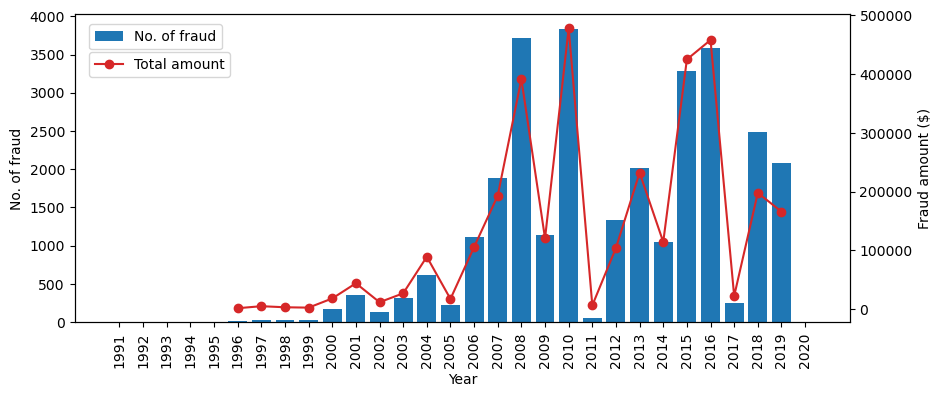

In [121]:
fig, ax = plt.subplots(figsize=(10, 4))

ax2 = ax.twinx()

x = data.groupby('year', as_index=True)['isFraud'].sum()
y = data.loc[data.isFraud == 1].groupby('year')['Amount'].sum()

ax.bar(x.index, x.values, label='No. of fraud')
ax2.plot(y.index, y.values, c='tab:red', marker='o', label='Total amount')
ax.set_xticks(x.index, x.index, rotation=90)
ax.set_xlabel('Year')
ax.set_ylabel('No. of fraud')
ax2.set_ylabel('Fraud amount ($)')
ax.legend(loc='upper left', bbox_to_anchor=(0.01, 0.99))
ax2.legend(loc='upper left', bbox_to_anchor=(0.01, 0.9))

plt.show()

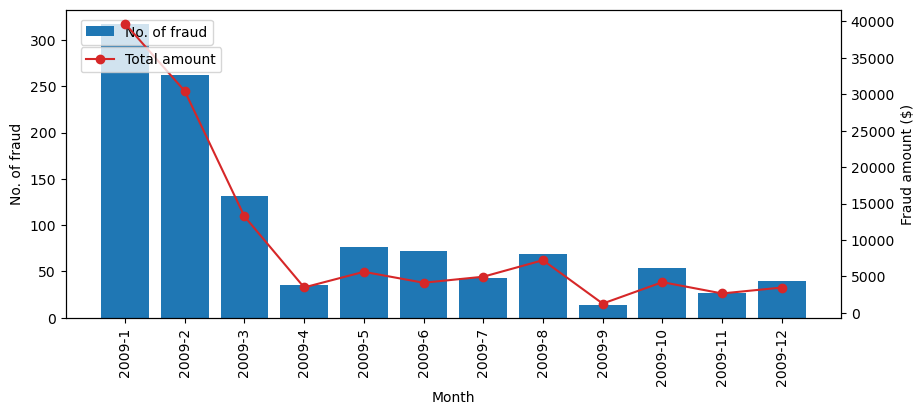

In [26]:
fig, ax = plt.subplots(figsize=(10, 4))

ax2 = ax.twinx()

x = data.groupby(['year', 'month'], as_index=True)['isFraud'].sum()
y = data.loc[data.isFraud == 1].groupby(['year', 'month'])['Amount'].sum()

ax.bar(x.index.map(lambda x: f'{x[0]}-{x[1]}'), x.values, label='No. of fraud')
ax2.plot(y.index.map(lambda x: f'{x[0]}-{x[1]}'), y.values, c='tab:red', marker='o', label='Total amount')
ax.set_xticks(x.index.map(lambda x: f'{x[0]}-{x[1]}'), x.index.map(lambda x: f'{x[0]}-{x[1]}'), rotation=90)
ax.set_xlabel('Month')
ax.set_ylabel('No. of fraud')
ax2.set_ylabel('Fraud amount ($)')
ax.legend(loc='upper left', bbox_to_anchor=(0.01, 0.99))
ax2.legend(loc='upper left', bbox_to_anchor=(0.01, 0.9))

plt.show()

# Preprocess data

In [6]:
# --- Preprocessing raw data ---
def preprocess_data(df):
    ''' Preprocess raw data. '''

    # Rename columns
    df.rename(columns={'Merchant Name':'MerchantName', 
                       'Merchant City':'MerchantCity', 
                       'Is Fraud?':'isFraud', 
                       'Merchant State':'MerchantState',
                       'Errors?':'Error'
                      },
              inplace=True
             )
    
    # Convert 'Amount' to fload
    df.Amount = df.Amount.str[1:].astype(float)

    # Convert 'UseChip' to numeric 'merchantNum'
    UseChipStr_to_UseChipNum = {UseChipStr:UseChipNum for UseChipNum, UseChipStr in enumerate(df['Use Chip'].unique())}
    df['UseChip'] = df['Use Chip'].map(UseChipStr_to_UseChipNum)
    df.drop('Use Chip', axis=1, inplace=True)
    
    # Replace fraud flags by 0 and 1
    df.isFraud = df.isFraud.replace({'No':0, 'Yes':1}).astype(int)
    
    # Join date and time and converto to datetime: transactionTime
    transactionTime = pd.to_datetime(df.Year.astype(str) + '-' 
                                     + df.Month.astype(str) + '-' 
                                     + df.Day.astype(str) + ' ' 
                                     + df.Time.astype(str))
    df.insert(0, 'transactionTime', transactionTime)
    
    # Sort dataframe by transaction time
    df = df.sort_values(by='transactionTime')
    
    # General temporal features
    df.insert(1, 'hour', df['transactionTime'].dt.hour)
    df.insert(1, 'weekday', df['transactionTime'].dt.dayofweek)
    df.insert(1, 'month', df['transactionTime'].dt.month)
    df.insert(1, 'year', df['transactionTime'].dt.year)
    
    df.drop(['Year', 'Month', 'Day', 'Time'], axis=1, inplace=True)
    
    # Imput a value for missing values
    df.MerchantState = df.MerchantState.fillna('Missing')
    df.Zip = df.Zip.fillna(0)
    # No error variable
    df.Error = df.Error.fillna('NoError')

    return df

# Define features

In [7]:
# Rolling time window for user lever patterns
time_window='7D'

# --- Predictors

# Numerical variables
num_vars = ['Amount', 
            # 'userTxMean',
            # 'userTxMedian',
            # 'userTxStd',
            # 'userTxMax',
            # 'userTxMin',
            # 'userTxFreq',
            # 'userMerchant',
            # 'userMCC',
            # 'userCity',
            # 'userState',
            # 'userZip'
           ]
# Frequency encoding variables
freq_enc_vars = ['hour']
# Target encoding variables
target_enc_vars = ['MerchantName', 'MerchantCity',  'MerchantState', 'Zip', 'MCC']
# One-hot encoding variables
onehot_enc_vars = ['weekday', 'UseChip']
# List of predictors
var_cols = num_vars+freq_enc_vars+target_enc_vars+onehot_enc_vars

# Logging configuration
# logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Feature engineering

In [35]:
df.head()

,transactionTime,year,month,weekday,hour,User,Card,Amount,UseChip,MerchantName,MerchantCity,MerchantState,Zip,MCC,Error,isFraud,MerchantCityNum,MerchantStateNum
0,2008-01-01 00:00:00,2008,1,1,0,1911,4,19.23,0,5232322915998164853,Kissimmee,FL,34746.0,5813,NoError,0,0,0
1,2008-01-01 00:02:00,2008,1,1,0,583,2,97.29,0,3467663023930633227,Houston,TX,77047.0,5912,NoError,0,1,1
2,2008-01-01 00:05:00,2008,1,1,0,34,1,2.72,0,-4500542936415012428,Mobile,AL,36693.0,5814,NoError,0,2,2
3,2008-01-01 00:08:00,2008,1,1,0,928,2,160.00,0,-4282466774399734331,South Hill,VA,23970.0,4829,NoError,0,3,3
4,2008-01-01 00:08:00,2008,1,1,0,1497,2,140.00,0,-4282466774399734331,Crown Point,IN,46307.0,4829,NoError,0,4,4


In [36]:
df.head().rolling(time_window, on='transactionTime')['Amount'].mean()

ValueError: window must be an integer 0 or greater

In [31]:
# --- Feature engineering ---

def convert_to_numeric(df, feature):
    featureStr_to_featureNum = {iStr:iNum for iNum, iStr in enumerate(df[feature].unique())}
    return df[feature].map(featureStr_to_featureNum)
    
def feature_engineering(df):
    ''' Create new variables from data variables. '''

    # Convert 'MerchantCity' to numeric 'MerchantCityNum'
    df['MerchantCityNum'] = convert_to_numeric(df, 'MerchantCity')

    # Convert 'MerchantState' to numeric 'MerchantStateNum'
    df['MerchantStateNum'] = convert_to_numeric(df, 'MerchantState')

    # User level patterns
    dfnew = pd.DataFrame()
    for _ , gdata in df.groupby('User'):
        
        # Transaction patterns
        gdata['userTxMean'] = gdata.rolling(time_window, on='transactionTime')['Amount'].mean()
        gdata['userTxMedian'] = gdata.rolling(time_window, on='transactionTime')['Amount'].median()
        gdata['userTxStd'] = gdata.rolling(time_window, on='transactionTime')['Amount'].std().fillna(0)
        gdata['userTxMax'] = gdata.rolling(time_window, on='transactionTime')['Amount'].max()
        gdata['userTxMin'] = gdata.rolling(time_window, on='transactionTime')['Amount'].min()
        gdata['userTxFreq'] = gdata.rolling(time_window, on='transactionTime')['Amount'].count()
    
        # Merchant patterns
        gdata['userMerchant'] = gdata.rolling(time_window, on='transactionTime')['MerchantName'].apply(lambda x: x.nunique())
        gdata['userMCC'] = gdata.rolling(time_window, on='transactionTime')['MCC'].apply(lambda x: x.nunique())
    
        # Geographical patterns
        gdata['userCity'] = gdata.rolling(time_window, on='transactionTime')['MerchantCityNum'].apply(lambda x: x.nunique())
        gdata['userState'] = gdata.rolling(time_window, on='transactionTime')['MerchantStateNum'].apply(lambda x: x.nunique())
        gdata['userZip'] = gdata.rolling(time_window, on='transactionTime')['Zip'].apply(lambda x: x.nunique())
        
        dfnew = pd.concat([dfnew, gdata])
    df = dfnew.sort_values(by='transactionTime')

    return df


# Encoding/Scaling

In [8]:
# --- Encoding/Scaling ---
def onehot_transform(df, ohe_vars):
    ''' One-hot encoder. '''
    # Define one-hot encoder
    onehot_encoder = OneHotEncoder(sparse_output=False)
    
    # Fit-transform variables
    df_onehot = pd.DataFrame(onehot_encoder.fit_transform(df[ohe_vars].astype('str')))
    df_onehot.columns = onehot_encoder.get_feature_names_out()
    df_onehot.index = df.index
    
    # Remove original categorical variables
    df.drop(ohe_vars, axis=1, inplace=True)
    
    # Concatenate data set with one-hot columns
    df = pd.concat([df, df_onehot], axis=1)
    return df
def encode_scale_data(X_train, X_test, y_train, num_vars, target_enc_vars, freq_enc_vars, onehot_enc_vars):
    ''' Encode and scale data. '''
    pd.set_option('future.no_silent_downcasting', True)
    
    # Target encoding
    if target_enc_vars:
        target_encoder = TargetEncoder(cols=target_enc_vars)
        X_train = target_encoder.fit_transform(X_train, y_train)
        X_test = target_encoder.transform(X_test)
    
    # Frequency encoding
    if freq_enc_vars:
        freq_encoder = CountEncoder(cols=freq_enc_vars)
        X_train = freq_encoder.fit_transform(X_train, y_train)
        X_test = freq_encoder.transform(X_test)
    
    # Scaling
    scaler = StandardScaler(with_mean=True, with_std=True).set_output(transform="pandas")
    scale_cols = num_vars+target_enc_vars+freq_enc_vars
    scaler.fit(X_train[scale_cols])
    X_train = pd.concat([X_train.drop(scale_cols, axis=1), scaler.transform(X_train[scale_cols])], axis=1)
    X_test = pd.concat([X_test.drop(scale_cols, axis=1), scaler.transform(X_test[scale_cols])], axis=1)
    
    # One-hot encoding
    if onehot_enc_vars:
        X_train = onehot_transform(X_train, onehot_enc_vars)
        X_test = onehot_transform(X_test, onehot_enc_vars)

    return X_train, X_test

# Collinearity

In [47]:
# --- Collinearity ---
def remove_collinearity(X_train, X_test, num_vars, target_enc_vars, freq_enc_vars):
    ''' Remove high collinearity with VIF > 10. '''

    # Select columns
    vif_cols = num_vars+target_enc_vars+freq_enc_vars
    
    vif_removed_cols=[]
    while True:
        X_train_values = X_train[vif_cols].values
        
        # Variance Inflation Factor
        vif = pd.DataFrame()
        vif['Variable'] = vif_cols
        vif['VIF'] = [variance_inflation_factor(X_train_values, i) for i in range(X_train_values.shape[1])]
        vif = vif[vif.VIF > 10].sort_values(by='VIF', ascending=False)
        if vif.empty:
            break
    
        # Remove column with highest VIF (>10)
        vif_removed_cols.append(vif.iloc[0,0])
        X_train.drop(vif.iloc[0,0], axis=1, inplace=True)
        X_test.drop(vif.iloc[0,0], axis=1, inplace=True)
        vif_cols.remove(vif.iloc[0,0])
        logging.info(f'Remove column {vif.iloc[0,0]} with VIF = {vif.iloc[0,1]}')
        
    return X_train, X_test, vif_removed_cols

# Training model

In [9]:
def model_training(X_train_set, y_train_target, model):
    ''' Training the model.
        Models tested: Logistic Regression, Random Forest, LightLGB
    '''

    model.fit(X_train_set, y_train_target.values.ravel())

    return model

# Evaluate model

In [11]:
def evaluate_model(model, X_test, y_test):
    ''' Evaluate the model and return metrics obtained. '''
    
    # Model predictions
    pred = model.predict(X_test)
    # Prediction probabilities
    pred_prob = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    metrics = {
        'confusion_matrix': confusion_matrix(y_test, pred),
        'classification_report': classification_report(y_test, pred),
        'recall_score': recall_score(y_test, pred),
        'precision_score': precision_score(y_test, pred),
        'f1_score': f1_score(y_test, pred),
        'precision_recall_curve': precision_recall_curve(y_test, pred_prob),
        'roc_auc_score': roc_auc_score(y_test, pred_prob),
        'roc_curve': roc_curve(y_test, pred_prob)
    }

    return metrics


In [12]:
# --- Precision recall curve ---
def plot_precision_recall_curve(model_pr_curve, color='C0', lw=2, marker=None, ax=None, 
                                title_fs=12, axis_label_fs=12, axis_tick_fs=12):
    ''' Plot the precision-recall curve.'''
    # Compute the precision, recall and threshold
    precision, recall, thresholds = model_pr_curve
    
    # fig, ax = plt.subplots(figsize=(4.5, 4))
    if ax is None:
        ax = plt.gca()
    
    # Plot the curve
    ax.plot([0, 1], [0, 1], color='k', linestyle='--', lw=1)  # Plot the diagonal line (random classifier)
    ax.plot(recall, precision, color=color, marker=marker, lw=lw)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('Recall', fontsize=axis_label_fs)
    ax.set_ylabel('Precision', fontsize=axis_label_fs)
    ax.set_title('Precision-Recall Curve', fontsize=title_fs)
    ax.tick_params(labelsize=axis_tick_fs)
    ax.grid(True)

    plt.tight_layout()
    # plt.show()
    # plt.savefig('precision_recall_curve.png', dpi=500, bbox_inches='tight')

In [13]:
# Plot the ROC curve
def plot_roc_curve(model_roc_curve, model_roc_auc, color='C0', model_name=None, ax=None, 
                   lw=2, title_fs=12, axis_label_fs=12, legend_fs=10, axis_tick_fs=12):
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = model_roc_curve
    roc_auc = model_roc_auc

    # fig, ax = plt.subplots(figsize=(4.5, 4))
    if ax is None:
        ax = plt.gca()

    ax.plot([0, 1], [0, 1], color='k', linestyle='--', lw=1)  # Plot the diagonal line (random classifier)
    ax.plot(fpr, tpr, color=color, lw=lw, label=f'{model_name} (AUC = {roc_auc:.2f})')
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate (FPR)', fontsize=axis_label_fs)
    ax.set_ylabel('True Positive Rate (TPR)', fontsize=axis_label_fs)
    ax.set_title('ROC Curve', fontsize=title_fs)
    ax.legend(loc='lower right', fontsize=legend_fs)
    ax.tick_params(labelsize=axis_tick_fs)
    ax.grid(True)
    # plt.show()


# main()

In [ ]:
# --- main() function --- 
# def main(transaction_file):

In [8]:
# # Data Folder
# data_folder = '/Users/efonesca.dos.reis/mrm_fraud/datasets/TabFormer/'
# # data_folder = '/data_clear/elohim/ccf/TabFormer/'
# # File
# file_name = 'card_transaction.v1.csv'

In [14]:
%%time
# Load data
df = pd.DataFrame()
for year in [2001]:
    df = pd.concat([df, load_data('card_transaction.v1-'+str(year)+'.csv', data_folder)])
# Convert transaction time to datetime
df.transactionTime = pd.to_datetime(df.transactionTime)

CPU times: user 216 ms, sys: 31.6 ms, total: 248 ms
Wall time: 251 ms


In [15]:
%%time
# Preprocess data
# df = preprocess_data(df)

CPU times: user 6 μs, sys: 3 μs, total: 9 μs
Wall time: 15.3 μs


In [76]:
%%time
# Feature engineering
# df = feature_engineering(df)

CPU times: user 25.7 s, sys: 458 ms, total: 26.2 s
Wall time: 26.2 s


In [16]:
# Split data into Train/Test sets
X, y = df[var_cols], df['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [17]:
%%time
# Encode and scale data
X_train, X_test = encode_scale_data(X_train, X_test, y_train, num_vars, target_enc_vars, freq_enc_vars, onehot_enc_vars)

CPU times: user 580 ms, sys: 97.7 ms, total: 678 ms
Wall time: 679 ms


In [208]:
%%time
# Remove collinearity with VIF
X_train, X_test, vif_removed_cols = remove_collinearity(X_train, X_test, num_vars, target_enc_vars, freq_enc_vars)
logging.info(f'Removed columns due to collinearity: {vif_removed_cols}')

CPU times: user 1.82 s, sys: 1.06 s, total: 2.88 s
Wall time: 358 ms


In [18]:
# Class imbalance: oversample with SMOTE to treat class imbalance
smote = SMOTE(sampling_strategy='auto', random_state=1)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [259]:
# Train model

In [66]:
model_dict={}
model_dict['lr'] = LogisticRegression(class_weight='balanced')
# model_dict['rf'] = RandomForestClassifier(n_jobs=5, 
#                                       random_state=1,
#                                       criterion='log_loss',
#                                       class_weight='balanced',
#                                       verbose=False)
model_dict['lgbm'] = LGBMClassifier(objective='binary', is_unbalance=True)
model_dict['mlp'] = MLPClassifier()

model_name={'lr':'Logistic Regression', 'lgbm':'LightGBM', 'mlp':'MLP'}

In [72]:
%%time
model=dict()
metrics=dict()
for m in model_dict:
    print(m)
    model[m] = model_training(X_train, y_train, model_dict[m])
    metrics[m] = evaluate_model(model[m], X_test, y_test)
    print('ok')

lr
ok
lgbm
[LightGBM] [Info] Number of positive: 206095, number of negative: 206095
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3069
[LightGBM] [Info] Number of data points in the train set: 412190, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
ok
mlp
ok
CPU times: user 6min 39s, sys: 27.5 s, total: 7min 6s
Wall time: 43.9 s


In [ ]:
# --- MISSING ---
    # # Cross-validation
    # cross_validation(model, X_train_smote, y_train_smote)

In [ ]:

    # # Compute probabilites for all data transactions
    # df_all_pred_prob = all_transactions_pred_prob(model, X, y, df, vif_removed_cols, num_vars, target_enc_vars, freq_enc_vars, onehot_enc_vars)

    # # Plot figures
    # plot_feature_importance(model)
    # plot_precision_recall_curve(y_test, pred_prob)
    # plot_review_load(df_all_pred_prob, y_test, pred_prob)

    # return model, metrics

# Model performance

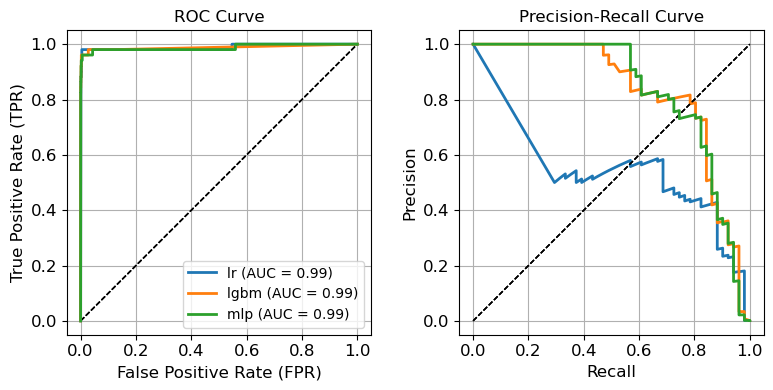

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))


for i, m in enumerate(model_dict.keys()):
    # ROC curve
    plot_roc_curve(metrics[m]['roc_curve'], metrics[m]['roc_auc_score'], model_name=m, color='C'+str(i), ax=ax[0])
    # PR curve
    plot_precision_recall_curve(metrics[m]['precision_recall_curve'], color='C'+str(i), ax=ax[1])

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
plt.show()

In [22]:
models_metrics=[]
for m in model_dict:
    models_metrics.append([metrics[m]['precision_score'], 
                           metrics[m]['recall_score'], 
                           metrics[m]['f1_score'], 
                           metrics[m]['roc_auc_score']])

pd.DataFrame(models_metrics, columns=['Precision', 'Recall', 'F1', 'ROC-AUC'], index=['LR', 'LGBM', 'MLP']).T

,LR,LGBM,MLP
Precision,0.131579,0.704918,0.605634
Recall,0.980392,0.843137,0.843137
F1,0.232019,0.767857,0.704918
ROC-AUC,0.988543,0.988305,0.987874


# Explainability

## SHAP

In [110]:
%%time
shap_values={}
explainer={}
for m in model_dict.keys():
    print(m)
    
    if m == 'mlp':
        pass
        # # Create SHAP Explainer for model
        # X_train_kmeans = shap.kmeans(X_train, 100) # Summarize train set with k mean samples
        # explainer = shap.KernelExplainer(model[m].predict, X_train_kmeans)
        # # Calculate SHAP values
        # shap_values[m] = explainer(X_test)
    else:
        # Create SHAP Explainer for model
        explainer[m] = shap.Explainer(model[m], X_train)
        # Calculate SHAP values
        shap_values[m] = explainer[m](X_test)
        
    print('ok')

lr
ok
lgbm


 99%|===================| 51012/51600 [00:54<00:00]        

ok
mlp
ok
CPU times: user 54.2 s, sys: 365 ms, total: 54.6 s
Wall time: 54.6 s


In [68]:
lr_featImportance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficients': model['lr'].coef_[0]
}).sort_values(by='Coefficients', ascending=True)

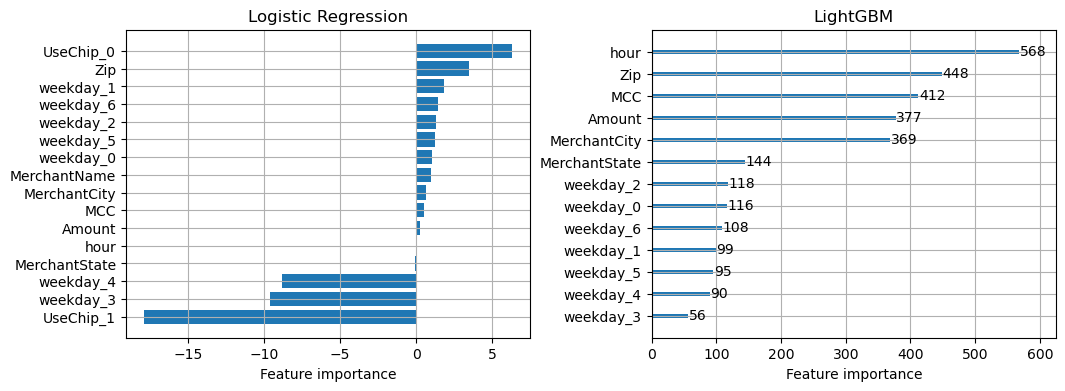

In [73]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].barh(lr_featImportance.Feature, lr_featImportance.Coefficients)
ax[0].set_title('Logistic Regression')
ax[0].set_xlabel('Feature importance')
ax[0].grid()

lgb.plot_importance(model_dict['lgbm'], importance_type='auto', ax=ax[1])
ax[1].set_ylabel('')
ax[1].set_title('LightGBM')

plt.subplots_adjust(wspace=0.3)

lr
lgbm


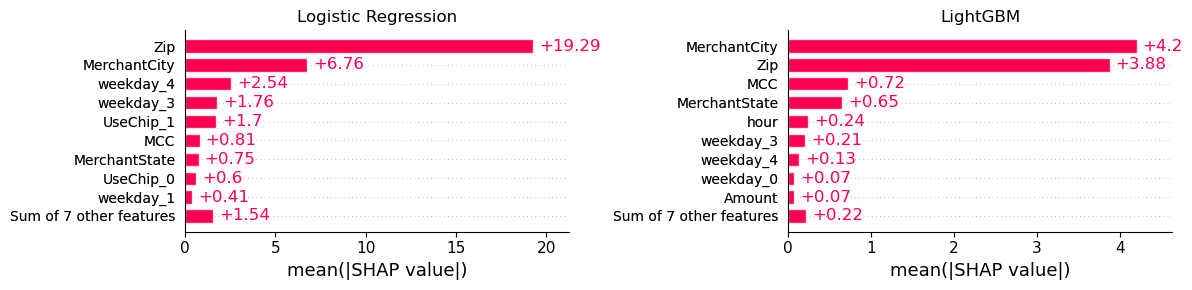

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(12, 3))

# plt.figure()
for i, m in enumerate(model_dict.keys()):
    if m == 'mlp':
        pass
    else:
        print(m)
        # plt.subplot(1, 2, i+1)
        shap.plots.bar(shap_values[m], ax=ax[i], show=False)
        # plt.xlabel_format(fontsize=10)
        ax[i].set_title(model_name[m])
        ax[i].tick_params(axis='y', which='major', labelsize=10)
plt.tight_layout()
plt.show()

lr
lgbm


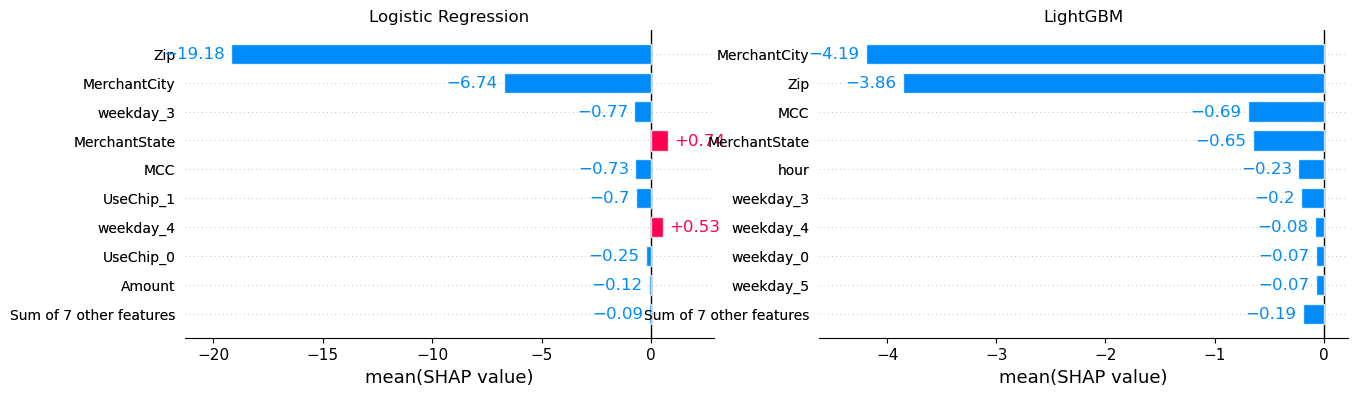

In [88]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# plt.figure()
for i, m in enumerate(model_dict.keys()):
    if m == 'mlp':
        pass
    else:
        print(m)
        # plt.subplot(1, 2, i+1)
        # shap.plots.bar(shap_values[m].min(0), ax=ax[i], show=False)
        # shap.plots.bar(shap_values[m].max(0), ax=ax[i], show=False)
        # shap.plots.bar(shap_values[m].abs.mean(0), ax=ax[i], show=False)
        shap.plots.bar(shap_values[m].mean(0), ax=ax[i], show=False)
        # plt.xlabel_format(fontsize=10)
        ax[i].set_title(model_name[m])
        ax[i].tick_params(axis='y', which='major', labelsize=10)
# plt.tight_layout()
plt.show()

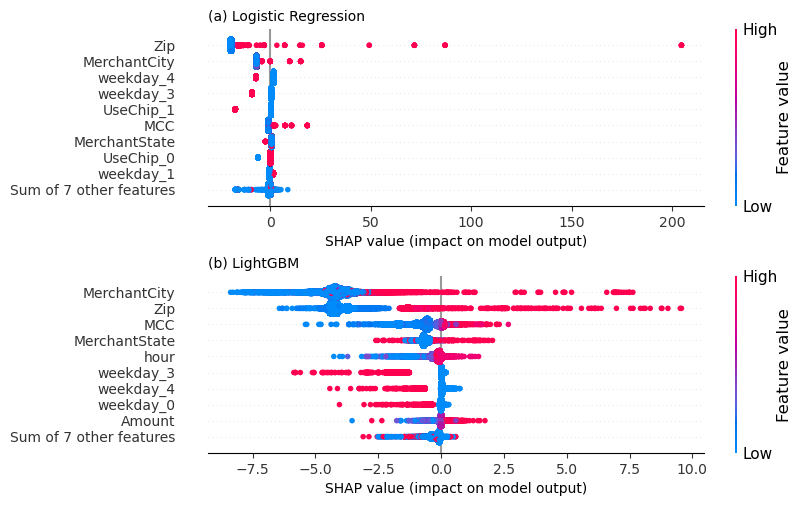

In [107]:
plt.figure(figsize=(12, 10))

title={0:'(a) ', 1:'(b) '}
for i, m in enumerate(['lr', 'lgbm']):
    plt.subplot(2, 1, i+1)
    shap.plots.beeswarm(shap_values[m], show=False)
    plt.title(title[i]+model_name[m], loc='left', fontsize=10)
    plt.tick_params(axis='both', labelsize=10)
    plt.gca().xaxis.label.set_size(10)
plt.subplots_adjust(hspace=0.4)
plt.show()

## 

## LIME